## 3a. Entrenamiento modelo Machine Learning

En este notebook implementaremos y compararemos dos modelos de Machine Learning:
1. **Logistic Regression**: funciona bien con representaciones bag-of-words
2. **MultinomialNB**: Modelo muy rápido y eficiente incluso con pocos datos de entreno.

### 3.1 Carga de datos y setup

In [21]:
import pandas as pd
import random
import numpy as np
from sklearn.model_selection import train_test_split # Modelado
from sklearn.pipeline import Pipeline # Modelado
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer # Modelado
from sklearn.feature_selection import chi2 # Reporte
from sklearn.linear_model import LogisticRegression # Reporte
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, precision_recall_curve # Reporte

import matplotlib.pyplot as plt

In [4]:
# Cargar DataFrame desde el archivo guardado en el notebook Carga y exploración
df = pd.read_pickle('outputs/df_beauty_preprocessed_ML.pkl')
print(f"DataFrame cargado: {len(df)} reviews")
df.head()

DataFrame cargado: 5992 reviews


,review_processed_ML,label_sentiment
0,nice wrong color loved braid didnt come color ...,0
1,nothing terrible eye bag ive using daily long ...,1
2,not fit hard put sonicare make loud buzzing no...,1
3,fix usable dried stick paper rip half disappoi...,1
4,keep coin start first wig horrible stiff look ...,1


### 3.2 Separo en conjunto de Train (75%) y Test(25%)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    df['review_processed_ML'],
    df['label_sentiment'],
    train_size=0.75,
    test_size=0.25,
    random_state=42,
    shuffle=True
)

In [8]:
X_train.iloc[:10]

4661    favorite radius brush favorite brush many year...
5114    love mix jojoba body love mix jojoba body daug...
5418    willie morrow unbreakable thermo blow dry nozz...
2675                                      non itchy light
4955    not used dhcs cleansing oil year like fine won...
4510    lasting good coverage foundation love foundati...
2309    tiny mighty got used morning update traveling ...
1673                                       dry little dry
1413    save money disappointed super cheap paint come...
4343    dont stick caption say people not stick well d...
Name: review_processed_ML, dtype: object

### 3.3 Extracción de caracteristicas con TF-IDF -CBOW

- Como estamos hablando de un dataset pequeño de 6000 reviews escogemos los parámetros de la siguiente manera como primer aaproximación:
- ngram_range: bigrama paara capturar pares de palabras (importante en analisis de sentimiento captura el "not good, very bad")
- max_features: 4000 para no tener overfitting
- min_df: 3 al menos para generalizar mejor
- max_df: 0.85 ignorando palabras muy comunes

In [9]:
cv = TfidfVectorizer(
    max_df=0.85,
    min_df=5,
    max_features=4000,
    strip_accents='ascii',
    ngram_range=(1, 2)
)

In [11]:
cv.fit(X_train)

print(f"Vocabulario TF-IDF: {len(cv.vocabulary_)} features")
print(f"Ejemplos de features: {list(cv.vocabulary_.keys())[:10]}")

Vocabulario TF-IDF: 2963 features
Ejemplos de features: ['favorite', 'brush', 'many', 'year', 'customer', 'happy', 'find', 'amazon', 'find amazon', 'love']


In [12]:
X_train_ = cv.transform(X_train)
X_test_ = cv.transform(X_test)

#### Analizamos las palabras más importantes de una review cualquiera según TF-IDF y así vemos cuales está teniendo en cuenta el modelo como más relevantes de cara a la clasificación

In [15]:
i = random.randint(0, len(X_train))
print('ID: {}'.format(i))
print('Sentiment: {}'.format(y_train.iloc[i]))
print('Review: {}'.format(X_train.iloc[i]))

ID: 3071
Sentiment: 1
Review: high hope not really impressed material pouch remind pencil pouch could dollar store packing diaper bag also noticed black dot showing clear part


In [16]:
doc_vector = X_train_[i]
df_tfidf = pd.DataFrame(doc_vector.T.todense(), index=cv.get_feature_names_out(), columns=['tfidf'])
df_tfidf = df_tfidf[df_tfidf['tfidf'] > 0]

top_n = 5
print('Top {} palabras con alto TF_IDF en la review {}:\n{}'.format(top_n, i, df_tfidf.sort_values(by=["tfidf"],ascending=False)[:top_n]))
print('\nTop {} palabras con bajo TF_IDF en la review {}:\n{}'.format(top_n, i, df_tfidf.sort_values(by=["tfidf"],ascending=False)[-top_n:]))

Top 5 palabras con alto TF_IDF en la review 3071:
               tfidf
pouch       0.496139
high hope   0.239718
packing     0.239718
pencil      0.233049
not really  0.225035

Top 5 palabras con bajo TF_IDF en la review 3071:
           tfidf
part    0.167954
could   0.147580
also    0.134260
really  0.116671
not     0.070172


<>:14: SyntaxWarning: invalid escape sequence '\c'
<>:16: SyntaxWarning: invalid escape sequence '\c'
<>:14: SyntaxWarning: invalid escape sequence '\c'
<>:16: SyntaxWarning: invalid escape sequence '\c'
/var/folders/vr/j_49s7z54f58kwyv69jtls9h0000gp/T/ipykernel_30850/109972082.py:14: SyntaxWarning: invalid escape sequence '\c'
  plt.xlabel('$\chi^2$', fontsize=26)
/var/folders/vr/j_49s7z54f58kwyv69jtls9h0000gp/T/ipykernel_30850/109972082.py:16: SyntaxWarning: invalid escape sequence '\c'
  plt.title('Top {} $\chi^2$ score for each word in the training set'.format(i), fontsize=20)


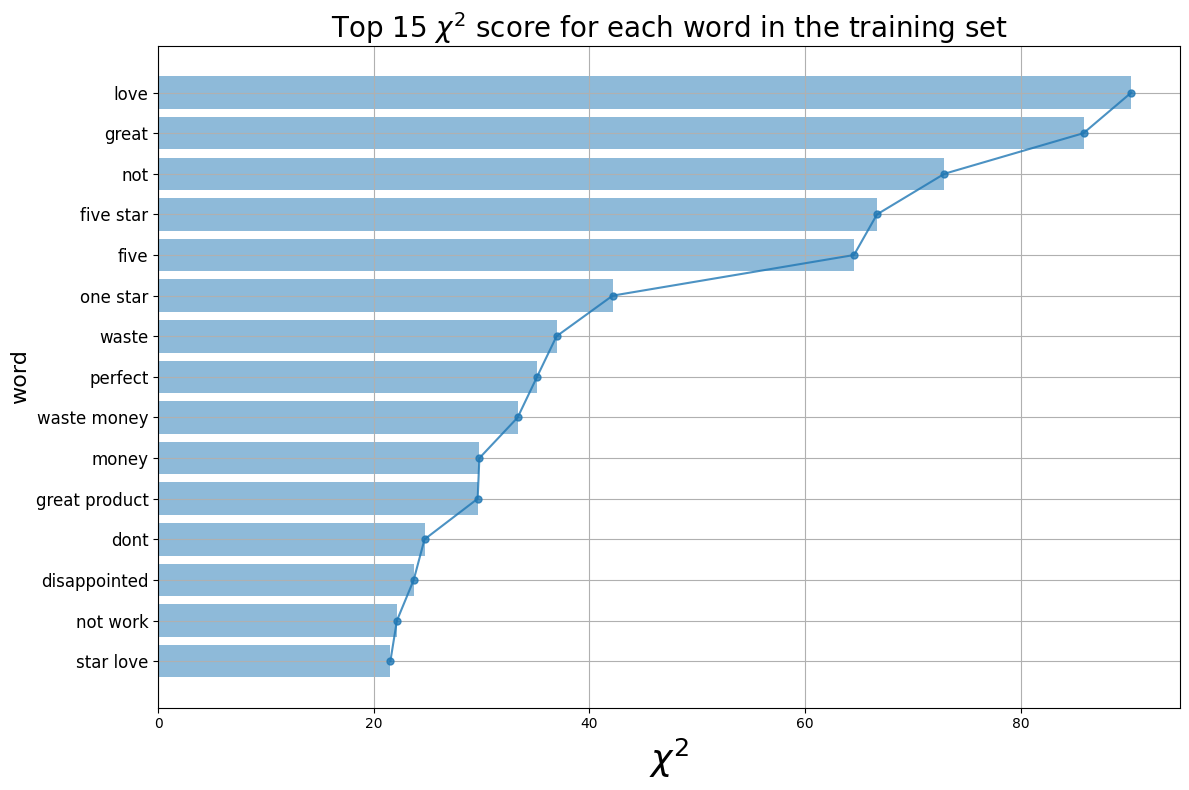

In [17]:
i = 15

chi2score = chi2(X_train_, y_train)[0]
scores = list(zip(cv.get_feature_names_out(), chi2score))
sorted_scores = sorted(scores, key=lambda x:x[1])
topchi2 = list(zip(*sorted_scores[-i:]))
x = range(len(topchi2[1]))
labels = topchi2[0]

plt.figure(figsize=(12, 8))
plt.barh(x,topchi2[1], align='center', alpha=0.5)
plt.plot(topchi2[1], x, '-o', markersize=5, alpha=0.8)
plt.yticks(x, labels, fontsize=12)
plt.xlabel('$\chi^2$', fontsize=26)
plt.ylabel('word', fontsize=16)
plt.title('Top {} $\chi^2$ score for each word in the training set'.format(i), fontsize=20)
plt.grid()
plt.tight_layout()
plt.show();

- Palabras como "waste", "waste money", "disappointed" probablemente indican reviews negativas
- Palabras como "love", "great", "perfect" probablemente indican reviews positivas

### 3.4 Modelo 1: `LogisticRegression` con búsqueda de mejor hiperparámetro

In [18]:
c_params = [0.01, 0.05, 0.25, 0.5, 1, 10, 100, 1000, 5000]

train_acc = list()
test_acc = list()
for c in c_params:
    lr = LogisticRegression(C=c, solver='lbfgs', max_iter=500)
    lr.fit(X_train_, y_train)

    train_predict = lr.predict(X_train_)
    test_predict = lr.predict(X_test_)

    print ("Accuracy for C={}: {}".format(c, accuracy_score(y_test, test_predict)))

    train_acc.append(accuracy_score(y_train, train_predict))
    test_acc.append(accuracy_score(y_test, test_predict))

Accuracy for C=0.01: 0.8678237650200267
Accuracy for C=0.05: 0.87716955941255
Accuracy for C=0.25: 0.8871829105473965
Accuracy for C=0.5: 0.8891855807743658
Accuracy for C=1: 0.8898531375166889
Accuracy for C=10: 0.8805073431241656
Accuracy for C=100: 0.8571428571428571
Accuracy for C=1000: 0.8484646194926568
Accuracy for C=5000: 0.8491321762349799


In [19]:
print('Confussion matrix:\n{}'.format(confusion_matrix(y_test, test_predict)))
print('\nClassification report:\n{}'.format(classification_report(y_test, test_predict)))
print('Accuracy score:{}'.format(accuracy_score(y_test, test_predict)))

Confussion matrix:
[[628 106]
 [120 644]]

Classification report:
              precision    recall  f1-score   support

           0       0.84      0.86      0.85       734
           1       0.86      0.84      0.85       764

    accuracy                           0.85      1498
   macro avg       0.85      0.85      0.85      1498
weighted avg       0.85      0.85      0.85      1498

Accuracy score:0.8491321762349799


#### Las métricas indican un buen modelo en general. Nno esta desbalanceado (F1-score sin sesgo hacia ninguna clase), pero esto ya lo habiamos "forzado" a que estuviera balanceado. Alto recall negativo, lo que indica que el modelo es sensible a detectar reviews negativas. 

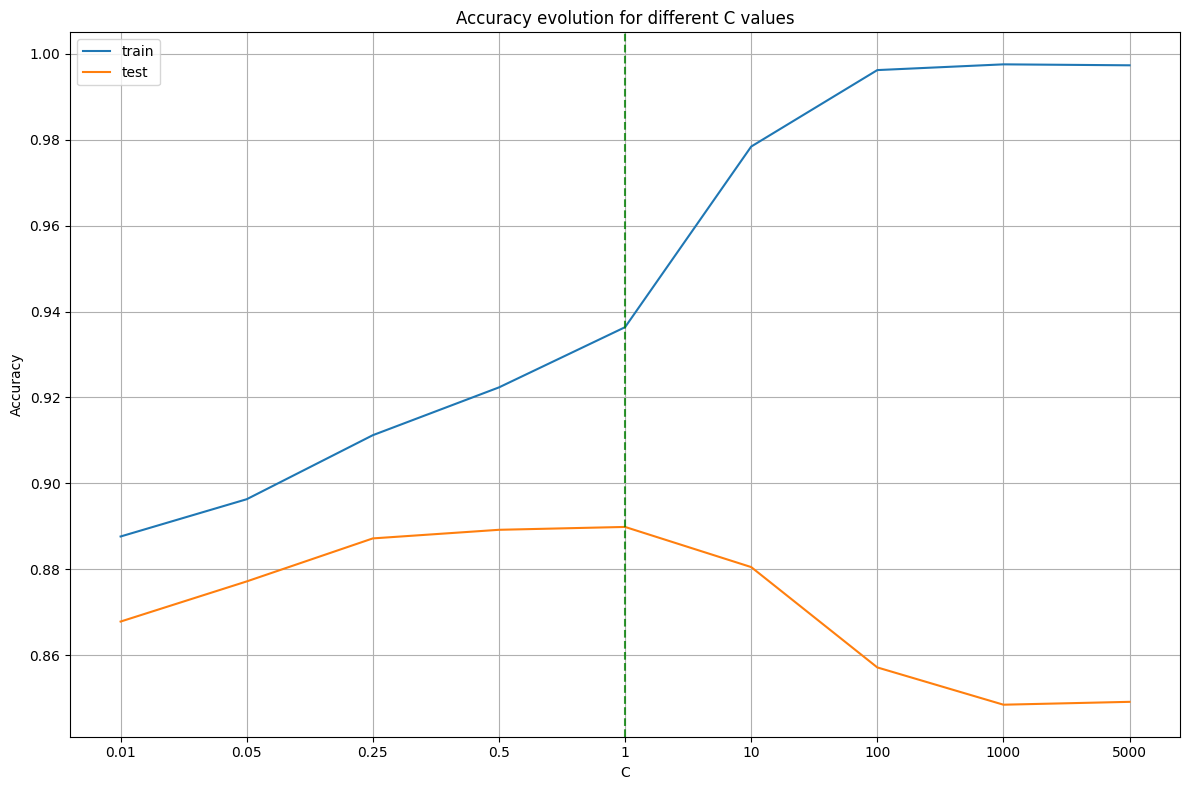

In [22]:
plt.figure(figsize=(12, 8))
plt.plot(train_acc, label='train')
plt.plot(test_acc, label='test')
plt.axvline(np.argmax(test_acc), c='g', ls='--', alpha=0.8)
plt.title('Accuracy evolution for different C values')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.xticks(list(range(len(c_params))), c_params)
plt.tight_layout()
plt.show()

#### Elegimos el valor de C donde test (linea naranja) alcanza el máximo antes de que empiece a bajar (C=1. acc=0.89) 

In [23]:
# Re-entreno con el mejor C (C=1)
best_c = 1
lr_final = LogisticRegression(C=best_c, solver='lbfgs', max_iter=500)
lr_final.fit(X_train_, y_train)

# Evaluar el modelo final
y_pred_final = lr_final.predict(X_test_)
print(f"Modelo final con C={best_c}")
print(f"Accuracy: {accuracy_score(y_test, y_pred_final):.4f}")
print(f"\nClassification Report:\n{classification_report(y_test, y_pred_final)}")

Modelo final con C=1
Accuracy: 0.8899

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.86      0.88       734
           1       0.87      0.91      0.89       764

    accuracy                           0.89      1498
   macro avg       0.89      0.89      0.89      1498
weighted avg       0.89      0.89      0.89      1498



In [28]:
p, r, thresholds = precision_recall_curve(y_test, test_predict)

In [29]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')

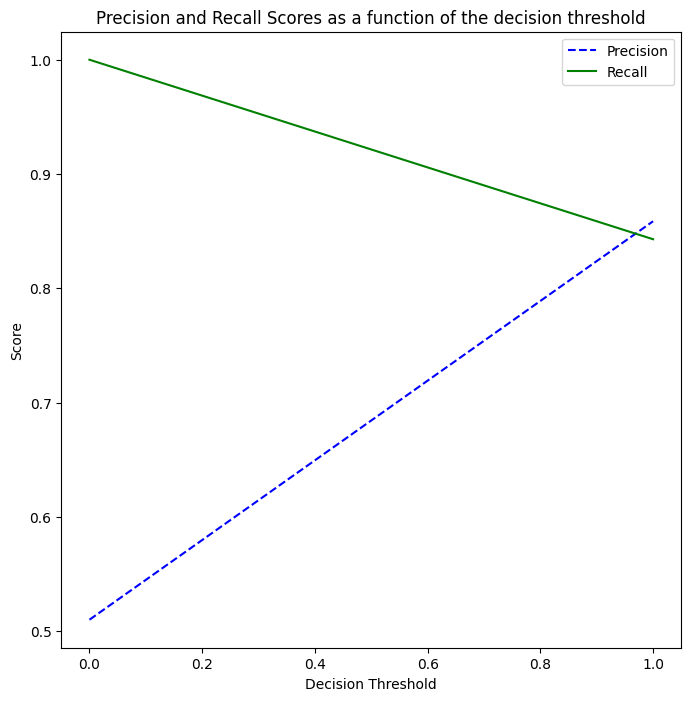

In [30]:
plot_precision_recall_vs_threshold(p, r, thresholds)

#### Algunos ejemplos de predicciones con este modelo:

In [50]:
def predict_review_sentiment(review_index, model):
    row = df.iloc[review_index]
    
    # Mostrar texto original si existe
    if 'reviewText' in df.columns:
        print(f'Review original: {row["reviewText"][:200]}...\n')
    
    # Obtener texto procesado 
    processed_text = row['review_processed_ML']
    if isinstance(processed_text, list):
        processed_text = ' '.join(str(word) for word in processed_text)
    else:
        processed_text = str(processed_text)
    
    print(f'Review procesada: {processed_text[:200]}...')
    
    # Sentimiento real
    actual = row['label_sentiment']
    sentiment_label = "Positivo" if actual == 1 else "Negativo"
    print(f'\nSentimiento real: {sentiment_label} ({actual})')
    
    # Predicción
    prediction = model.predict(cv.transform([processed_text]))[0]
    proba = model.predict_proba(cv.transform([processed_text]))[0]
    
    pred_label = "Positivo" if prediction == 1 else "Negativo"
    print(f'Predicción: {pred_label} ({prediction})')
    print(f'Probabilidades: Negativo={proba[0]:.1%}, Positivo={proba[1]:.1%}')
    
    match = "CORRECTO" if actual == prediction else "ERROR"
    print(f'\n{match}')


In [73]:
for i in random.sample(range(0, len(df)), 3):
    print('\nReview no. {}'.format(i))
    predict_review_sentiment(i, lr_final)


Review no. 1642
Review procesada: silicone bottle loved bottle used hosp stay appreciated convenience not full size bottle pack unpack...

Sentimiento real: Negativo (0)
Predicción: Negativo (0)
Probabilidades: Negativo=53.0%, Positivo=47.0%

CORRECTO

Review no. 4918
Review procesada: best purchase small risk ive always use product thought buying coming door step going super easy instead run nearest salon store hour away unfortunately came flimsy bag product leaked one bottle lucki...

Sentimiento real: Negativo (0)
Predicción: Positivo (1)
Probabilidades: Negativo=40.1%, Positivo=59.9%

ERROR

Review no. 1250
Review procesada: assistant adhesivenot didnt assist helping adhesive secure claim horrible...

Sentimiento real: Positivo (1)
Predicción: Positivo (1)
Probabilidades: Negativo=12.7%, Positivo=87.3%

CORRECTO


### 3.5 Modelo 2: `Naive Bayes (MultinomialNB)`

In [75]:
from sklearn.naive_bayes import MultinomialNB

In [76]:
# Entrenar Naive Bayes
nb_model = MultinomialNB()
nb_model.fit(X_train_, y_train)

,alpha,1.0
,force_alpha,True
,fit_prior,True
,class_prior,None


In [77]:
# Predicciones
y_pred_nb = nb_model.predict(X_test_)

In [78]:
# Evaluación
print("NAIVE BAYES - RESULTADOS")

print(f"Accuracy: {accuracy_score(y_test, y_pred_nb):.4f}")
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred_nb, target_names=['Positive', 'Negative']))
print(f"\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_nb))

NAIVE BAYES - RESULTADOS
Accuracy: 0.8798

Classification Report:
              precision    recall  f1-score   support

    Positive       0.88      0.87      0.88       734
    Negative       0.88      0.89      0.88       764

    accuracy                           0.88      1498
   macro avg       0.88      0.88      0.88      1498
weighted avg       0.88      0.88      0.88      1498


Confusion Matrix:
[[638  96]
 [ 84 680]]


### 3.6 Comparación de ambos modelos

In [ ]:
# Calcular métricas para los modelos
from sklearn.metrics import precision_score, recall_score, f1_score

models_results = {
    'Logistic Regression': {
        'predictions': y_pred_final,
        'model': lr_final
    },
    'Naive Bayes': {
        'predictions': y_pred_nb,
        'model': nb_model
    },
}

# Crear tabla comparativa
comparison_data = []
for model_name, results in models_results.items():
    y_pred = results['predictions']
    comparison_data.append({
        'Modelo': model_name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, average='weighted'),
        'Recall': recall_score(y_test, y_pred, average='weighted'),
        'F1-Score': f1_score(y_test, y_pred, average='weighted')
    })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.round(4)

print("COMPARACIÓN DE MODELOS")
print(comparison_df.to_string(index=False))

COMPARACIÓN DE MODELOS
             Modelo  Accuracy  Precision  Recall  F1-Score
Logistic Regression    0.8899     0.8906  0.8899    0.8897
        Naive Bayes    0.8798     0.8799  0.8798    0.8798


**Análisis de resultados:**

1. **Vectorización (TF-IDF)**:
   - TF-IDF capturó mejor las palabras informativas al ponderar por frecuencia inversa
   - Redujo el peso de palabras muy comunes que no aportan información
   - Generó features más discriminativas para el clasificador

2. **Comparación de Modelos**:
   - **Logistic Regression**: Buen equilibrio entre precisión y recall, interpretable
   - **Naive Bayes**: Rápido de entrenar, asume independencia entre features

3. **Observaciones**:
   - Los dos modelos tienen rendimiento similar, lo que sugiere que el preprocesado fue efectivo
   - La vectorización TF-IDF fue clave para el buen desempeño


### 3.7 Guardar modelo final elegido y vectorizador

In [83]:
# Seleccionar el modelo con mejor F1-Score
best_model_name = comparison_df.loc[comparison_df['F1-Score'].idxmax(), 'Modelo']
best_model = models_results[best_model_name]['model']

print("\n" + "="*80)
print("MODELO FINAL SELECCIONADO")
print("="*80)
print(f"\nModelo elegido: {best_model_name}")
print(f"\nJustificación:")
print(f"- Mejor F1-Score: {comparison_df.loc[comparison_df['F1-Score'].idxmax(), 'F1-Score']:.4f}")
print(f"- Buen equilibrio entre precisión y recall")
print(f"- Adecuado para el problema de sentiment analysis")
print("\n" + "="*80)

# Guardar modelo final
import pickle
import os

os.makedirs('outputs', exist_ok=True)
with open('outputs/final_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)
with open('outputs/vectorizer.pkl', 'wb') as f:
    pickle.dump(cv, f)

print("\n✓ Modelo y vectorizador guardados en outputs/")


MODELO FINAL SELECCIONADO

Modelo elegido: Logistic Regression

Justificación:
- Mejor F1-Score: 0.8897
- Buen equilibrio entre precisión y recall
- Adecuado para el problema de sentiment analysis


✓ Modelo y vectorizador guardados en outputs/
